# Forecasting Hourly Taxi Orders Using Machine Learning

## Introduction

The goal of this project is to develop a predictive model to forecast the number of taxi orders at airports for the next hour. By accurately predicting demand, the Sweet Lift Taxi company aims to attract more drivers during peak hours, thereby improving service efficiency and customer satisfaction. This project involves:

- Analyzing historical data on taxi orders.
- Resampling the data to hourly intervals.
- Training various machine learning models with different hyperparameters.
- Evaluating their performance using the Root Mean Squared Error (RMSE) metric.

The final model's RMSE on the test set should not exceed 48, ensuring reliable predictions to better manage driver availability during peak times.


In [1]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Set autolayout to True
plt.rcParams['figure.autolayout'] = True

import seaborn as sns
from tqdm import tqdm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor

from pmdarima import auto_arima

In [2]:
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['{}h_rolling_mean'.format(rolling_mean_size)] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

In [3]:
# Read the data from the CSV file

try:
    df = pd.read_csv('data/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
# Sort the data
df.sort_index(inplace=True)

## Initial Inspection

In [5]:
# Display some basic information
df.info()
display(df.head(3))
display(df.tail(3))
df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28


,num_orders
datetime,
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
def confirm_chronology():
    # Check some more basics on the chronology
    print("The data is monotonic:",df.index.is_monotonic_increasing)

    ### Check for missing or duplicate intervals ###
    # Generate a complete range of datetime values at ten-minute intervals
    full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='10T')

    # Identify missing intervals by comparing the generated range with the existing index
    missing_intervals = full_range.difference(df.index)
    
    # Check if there are any missing intervals
    if not missing_intervals.empty:
        print(f"Missing intervals found: {missing_intervals}")
    else:
        print("No missing intervals.")

    # Check for duplicate intervals
    duplicate_intervals = df.index.duplicated()
    if duplicate_intervals.any():
        print(f"Duplicate intervals found: {df.index[duplicate_intervals]}")
    else:
        print("No duplicate intervals.")
        
    print(f"The data starts at {df.index.min()} and ends at {df.index.max()}")

confirm_chronology()

The data is monotonic: True
No missing intervals.
No duplicate intervals.
The data starts at 2018-03-01 00:00:00 and ends at 2018-08-31 23:50:00


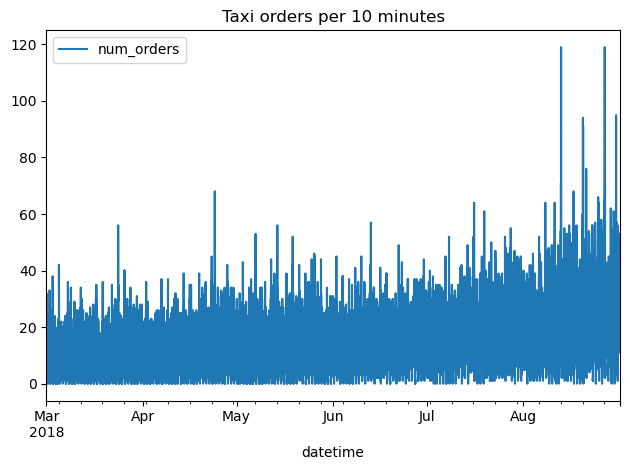

In [7]:
# Visualize the data as is
df.plot()
plt.title("Taxi orders per 10 minutes")
plt.show()

Our data spans the from 2018-03-01 00:00:00 to 2018-08-31 23:50:00, and is recorded in 10 minute intervals. We have confirmed that each ten minute interval is present and there are no duplicate timestamps. As it stands, the data is too granular for the our purposes - we want to make predictions for the next hour. 

It is important to note that our dataset is only 6 complete months, meaning it will be impossible to understand seasonality on an annual basis.


## Analyze the Data
First we will resample the data to show total orders per hour, then visualize again.

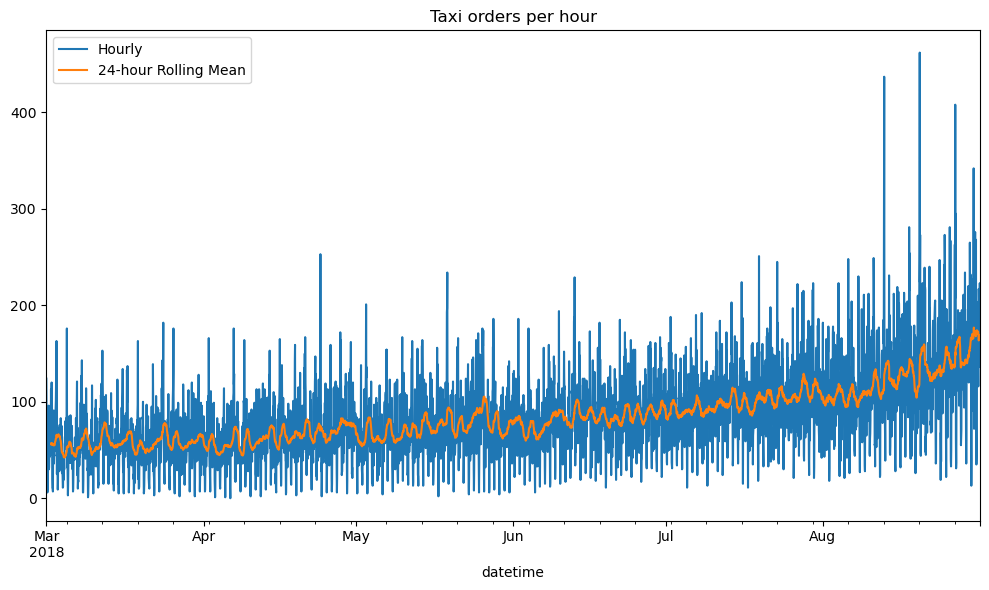

In [8]:
# Resample the data to hourly frequency
df = df.resample('1H').sum()

# Visualize the resampled data
df['num_orders'].plot(label='Hourly')

# visualize 24-hour rolling mean
df['num_orders'].rolling(24).mean().plot(label='24-hour Rolling Mean', figsize=(10, 6))

plt.title("Taxi orders per hour")
plt.legend()
plt.show()

In [9]:
def plot_decomposition(column, title="", period=None, dayofweek=False):
    
    # Perform the seasonal decomposition
    decomposition = seasonal_decompose(column, period=period)

    # Plot the components
    fig, ax = plt.subplots(4, 1, figsize=(10, 6), sharex=True)
    fig.suptitle(title, fontsize=16)
    
    ax[0].set_title('Observed')
    ax[1].set_title('Trend')
    ax[2].set_title('Seasonal')
    ax[3].set_title('Residual')

    decomposition.observed.plot(ax=ax[0])
    decomposition.trend.plot(ax=ax[1])
    decomposition.seasonal.plot(ax=ax[2])
    decomposition.resid.plot(ax=ax[3])

    ax[3].set_xlabel('DateTime')

    if dayofweek:
        # Set the x-tick labels to day of the week
        ticks = column.index[::period]  # Adjust this as necessary
        tick_labels = [tick.strftime('%A') for tick in ticks]
        ax[3].set_xticks(ticks)
        ax[3].set_xticklabels(tick_labels, rotation=45)

    plt.show()

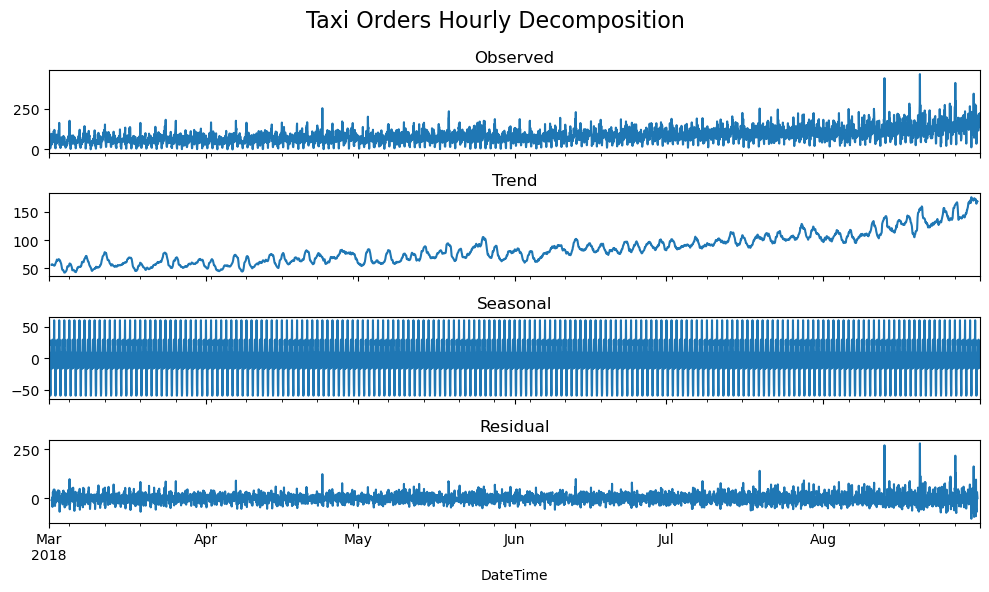

In [10]:
plot_decomposition(df['num_orders'], title="Taxi Orders Hourly Decomposition", period=24)

Across the entire dataset, we can see a clear raising trend in taxi orders as time goes on. The trend is relatively flat in the spring months, then picks up as summer progresses. We also see seasonality, but on a much smaller time scale. Let's take a look at smaller slices of the data to further visualize the seasonality.

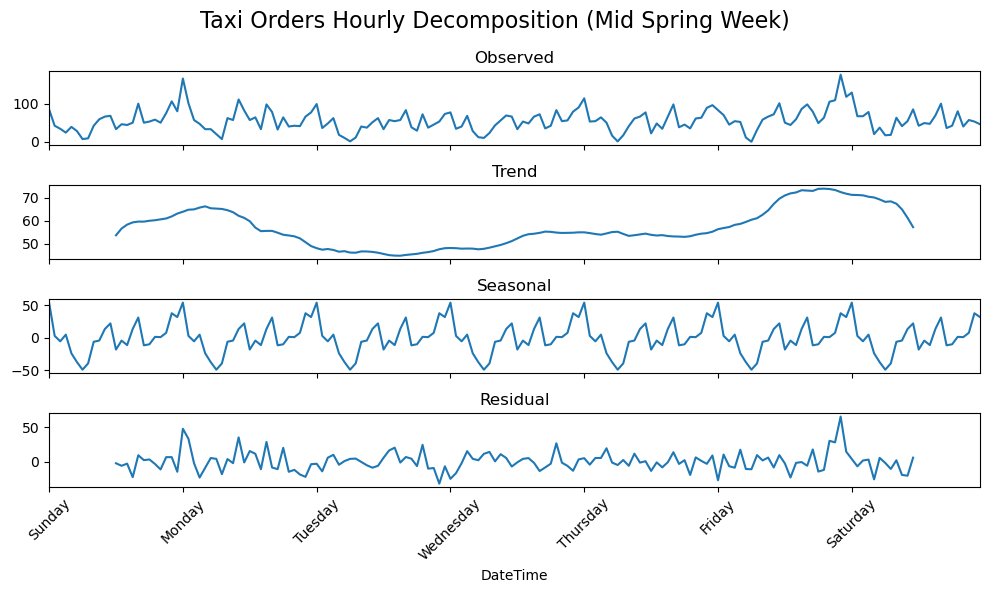

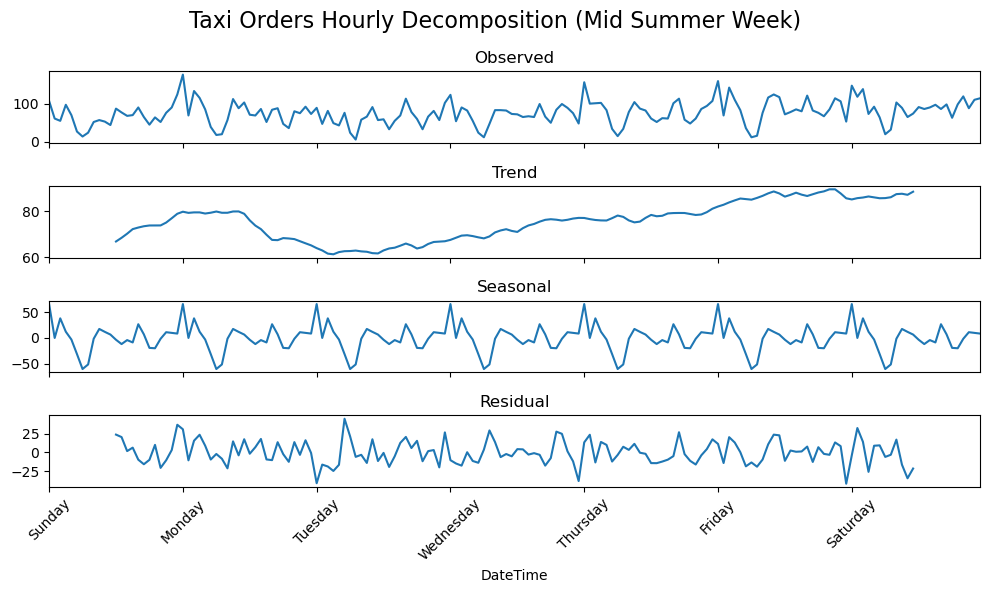

In [11]:
plot_decomposition(df['num_orders'].loc['2018-04-01':'2018-04-07'], title="Taxi Orders Hourly Decomposition (Mid Spring Week)", period=24, dayofweek=True)
plot_decomposition(df['num_orders'].loc['2018-06-03':'2018-06-09'], title="Taxi Orders Hourly Decomposition (Mid Summer Week)", period=24, dayofweek=True)

In both samples we can see clear daily seasonality, which makes sense - certain times of day are consistently busier than others. Notably, it looks like midnight is the busiest time, with a sharp decline in the early morning before picking up again in the evening.

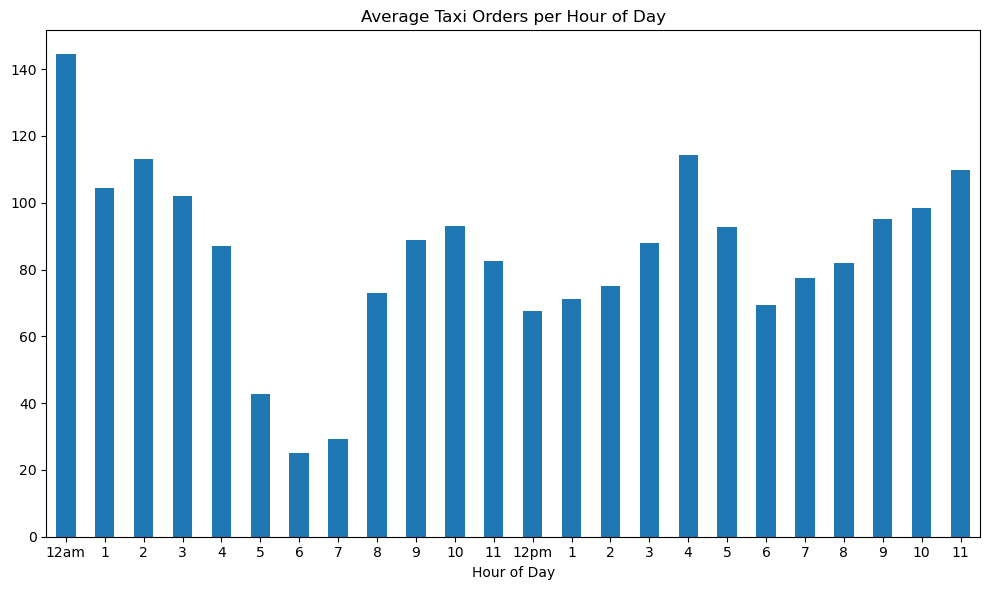

In [12]:
# Plot average orders per hour of day
plt.figure(figsize=(10, 6))
df.groupby(df.index.hour)['num_orders'].mean().plot(kind='bar')
plt.title("Average Taxi Orders per Hour of Day")
plt.xlabel("Hour of Day")
plt.xticks(rotation=0, ticks=range(24), labels=['12am', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12pm', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])
plt.show()

The bar graph allows us to see more clearly the hourly pattern of orders. There is a sharp uptick at 4pm with a drop off over the next two hours. Orders then begin an upward trend around 7pm that continues through midnight, with less but still strong demand for orders up until 4am.

By resampling the data to a daily interval, we can more clearly explore if there is a weekly seasonality as well.

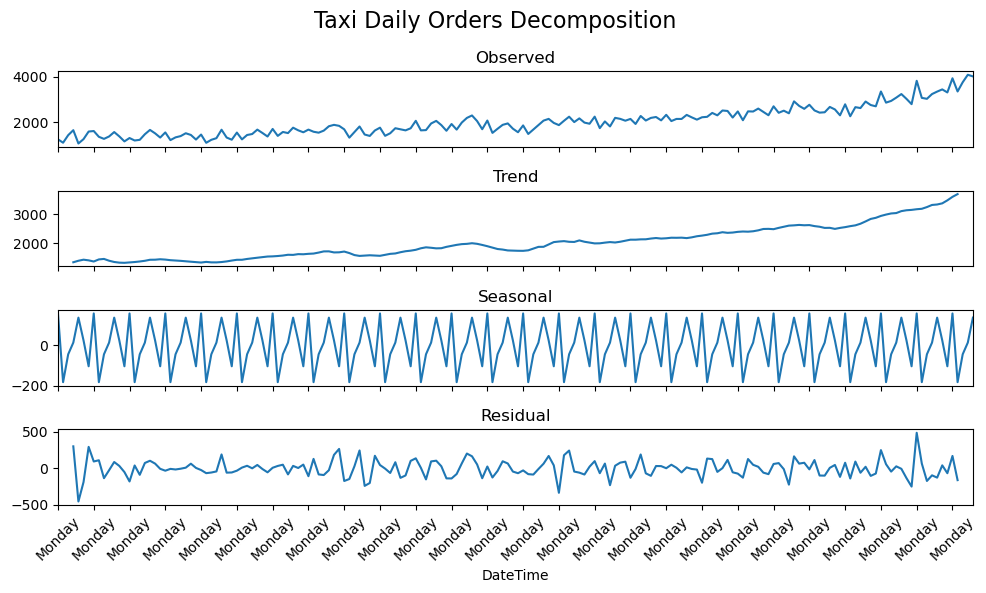

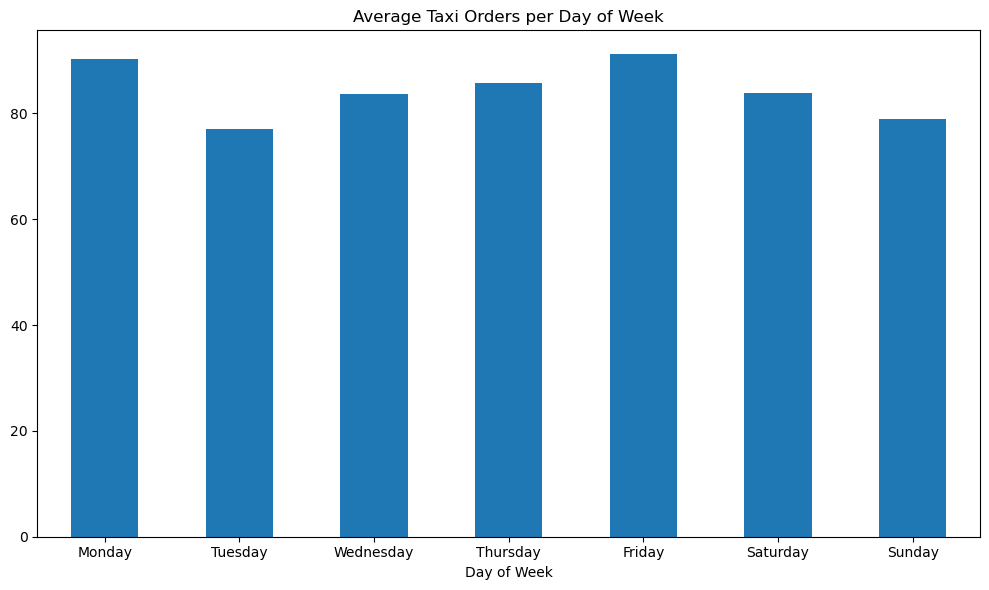

In [13]:
plot_decomposition(df['num_orders'].loc['2018-03-05':].resample('1D').sum(), title="Taxi Daily Orders Decomposition", period=7, dayofweek=True) # Start from March 5th since that is the first Monday in the dataset, aligns with bar chart

# Plot average orders per day of week
plt.figure(figsize=(10, 6))
df.groupby(df.index.dayofweek)['num_orders'].mean().plot(kind='bar')
plt.title("Average Taxi Orders per Day of Week")
plt.xlabel("Day of Week")
plt.xticks(rotation=0, ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

Similarly we see there is weekly seasonality, with two peaks per week on Mondays and Fridays. Also note the the upward trend across the entire dataset is more obvious with this level of smoothing. We can also visualize this by plotting the average orders per month.

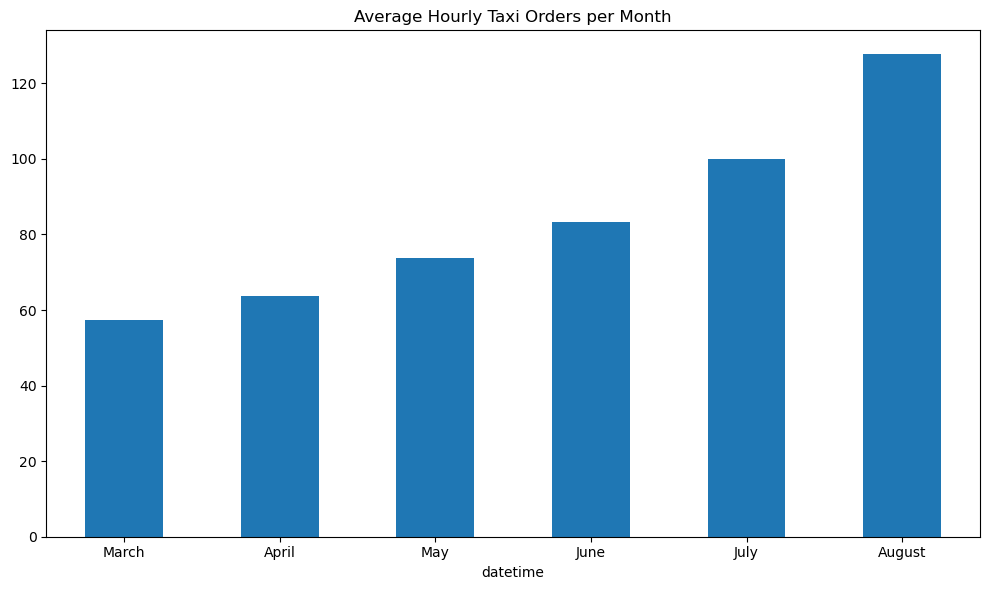

In [14]:
# Plot average orders per month
plt.figure(figsize=(10, 6))
df.groupby(df.index.month)['num_orders'].mean().plot(kind='bar')
plt.title("Average Hourly Taxi Orders per Month")
plt.xticks(rotation=0, ticks=range(0, 6), labels=['March', 'April', 'May', 'June', 'July', 'August'])
plt.show()

## Train Models

In [15]:
tune_models = input("Do you want to tune the models? The best results are hardcoded to save time if not. (y/n): ")

if tune_models.lower() == 'y':
    tune_models = True
else:
    tune_models = False


### Baseline - Predict Previous

In [16]:
def pred_by_previous(df):
    
    # Split the data into training and testing sets
    train, test = train_test_split(df, shuffle=False, test_size=0.2)
    valid, test = train_test_split(test, shuffle=False, test_size=0.5)
    
    pred = valid.shift()
    pred.iloc[0] = train.iloc[-1]
    
    # Calculate the RMSE
    rmse = np.sqrt(mean_squared_error(valid, pred))
    
    # Store the results
    results = {
        'description': "Predict Previous",
        'best_valid_score': rmse,
        'best_lag': None,
        'best_rolling_mean': None,
        'best_params': {}
    }
    
    return results


In [17]:
pred_prev_results = pred_by_previous(df)
print(pred_prev_results)

{'description': 'Predict Previous', 'best_valid_score': 47.246345832986236, 'best_lag': None, 'best_rolling_mean': None, 'best_params': {}}


### Linear Regression

In [18]:
def tune_linear_regression(df):
    
    lags = range(2, 37, 2)
    rolling_means = range(4, 25, 4)

    best_valid_score = np.inf
    best_lag = None
    best_rolling_mean = None
    
    with tqdm(total=len(lags) * len(rolling_means), desc="Tunning Progress") as pbar:
        for lag in lags:
            for rolling_mean in rolling_means:
                # Make features
                data = make_features(df, lag, rolling_mean).dropna()

                # Split data
                train, test = train_test_split(data, shuffle=False, test_size=0.2)
                valid, test = train_test_split(test, shuffle=False, test_size=0.5)

                # Define features and target
                X_train = train.drop('num_orders', axis=1)
                y_train = train['num_orders']
                X_valid = valid.drop('num_orders', axis=1)
                y_valid = valid['num_orders']

                # Define the model
                model = LinearRegression()

                # Fit the model
                model.fit(X_train, y_train)

                # Make predictions
                pred = model.predict(X_valid)

                # Calculate the score
                score = mean_squared_error(y_valid, pred, squared=False)

                if score < best_valid_score:
                    best_valid_score = score
                    best_lag = lag
                    best_rolling_mean = rolling_mean

                # Update progress bar
                pbar.update(1)
        
        # Store results
        results = {
            'description': "Linear Regression",
            'best_valid_score': best_valid_score,
            'best_lag': best_lag,
            'best_rolling_mean': best_rolling_mean,
            'best_params': {}
        }

        return results

In [19]:
if tune_models:
    lr_results = tune_linear_regression(df)
else:
    lr_results = {'description': 'Linear Regression', 'best_valid_score': 33.89583769383211, 'best_lag': 34, 'best_rolling_mean': 8, 'best_params': {}}

print(lr_results)

Tunning Progress: 100%|██████████| 108/108 [00:01<00:00, 60.49it/s]

{'description': 'Linear Regression', 'best_valid_score': 33.89583769383211, 'best_lag': 34, 'best_rolling_mean': 8, 'best_params': {}}


### Random Forrest

In [20]:
def tune_random_forrest(df):
    
    lags = range(2, 37, 2)
    rolling_means = range(4, 25, 4)
    best_params = {}
    
    best_valid_score = np.inf
    best_lag = None
    best_rolling_mean = None
    
    params_dict = {'n_estimators': [10, 15],
                   'max_depth': [5, 10, 15]
    }
    
    with tqdm(total=len(lags) * len(rolling_means), desc="Tunning Progress") as pbar:
        for lag in lags:
            for rolling_mean in rolling_means:
                # Make features
                data = make_features(df, lag, rolling_mean).dropna()

                # Split data
                train, test = train_test_split(data, shuffle=False, test_size=0.2)
                valid, test = train_test_split(test, shuffle=False, test_size=0.5)

                # Define features and target
                X_train = train.drop('num_orders', axis=1)
                y_train = train['num_orders']
                X_valid = valid.drop('num_orders', axis=1)
                y_valid = valid['num_orders']

                # Define the model
                model = RandomForestRegressor(random_state=123)

                # Define the time series split
                tscv = TimeSeriesSplit(n_splits=3)
                
                # Define the grid search
                grid = GridSearchCV(model, params_dict, scoring='neg_mean_squared_error', cv=tscv)

                # Fit the model
                grid.fit(X_train, y_train)

                # Make predictions
                pred = grid.predict(X_valid)

                # Calculate the score
                score = mean_squared_error(y_valid, pred, squared=False)

                if score < best_valid_score:
                    best_valid_score = score
                    best_lag = lag
                    best_rolling_mean = rolling_mean
                    best_params = grid.best_params_

                # Update progress bar
                pbar.update(1)
        
        # Store results
        results = {
            'description': "Random Forest",
            'best_valid_score': best_valid_score,
            'best_lag': best_lag,
            'best_rolling_mean': best_rolling_mean,
            'best_params': best_params
        }

        return results

In [21]:
if tune_models:
    rf_results = tune_random_forrest(df)
else:
    rf_results = {'description': 'Random Forest', 'best_valid_score': 31.703192781271067, 'best_lag': 14, 'best_rolling_mean': 24, 'best_params': {'max_depth': 15, 'n_estimators': 15}}

print(rf_results)

Tunning Progress: 100%|██████████| 108/108 [04:29<00:00,  2.50s/it]

{'description': 'Random Forest', 'best_valid_score': 31.703192781271067, 'best_lag': 14, 'best_rolling_mean': 24, 'best_params': {'max_depth': 15, 'n_estimators': 15}}


### LightGBM

In [22]:
def tune_LGBM(df):
   
   lags = range(2, 37, 2)
   rolling_means = range(4, 25, 4)
   best_params = {}
   
   best_valid_score = np.inf
   best_lag = None
   best_rolling_mean = None
   
   # Define the parameter grid
   params_dict = {'n_estimators': [10, 15],
                  'max_depth': [5, 10, 15],
                  'learning_rate': [0.1, 0.3]
   }
   
   with tqdm(total=len(lags) * len(rolling_means), desc="Tunning Progress") as pbar:
         for lag in lags:
            for rolling_mean in rolling_means:
                  # Make features
                  data = make_features(df, lag, rolling_mean).dropna()
   
                  # Split data
                  train, test = train_test_split(data, shuffle=False, test_size=0.2)
                  valid, test = train_test_split(test, shuffle=False, test_size=0.5)
   
                  # Define features and target
                  X_train = train.drop('num_orders', axis=1)
                  y_train = train['num_orders']
                  X_valid = valid.drop('num_orders', axis=1)
                  y_valid = valid['num_orders']
   
                  # Define the model
                  model = LGBMRegressor(random_state=123)

                  # Define the time series split
                  tscv = TimeSeriesSplit(n_splits=3)
                  
                  # Define the grid search
                  grid = GridSearchCV(model, params_dict, scoring='neg_mean_squared_error', cv=tscv)
   
                  # Fit the model
                  grid.fit(X_train, y_train)
   
                  # Make predictions
                  pred = grid.predict(X_valid)
   
                  # Calculate the score
                  score = mean_squared_error(y_valid, pred, squared=False)
   
                  if score < best_valid_score:
                     best_valid_score = score
                     best_lag = lag
                     best_rolling_mean = rolling_mean
                     best_params = grid.best_params_
   
                  # Update progress bar
                  pbar.update(1)
         
         # Store results
         results = {
            'description': "LightGBM",
            'best_valid_score': best_valid_score,
            'best_lag': best_lag,
            'best_rolling_mean': best_rolling_mean,
            'best_params': best_params
         }
   
         return results

In [23]:
if tune_models:
    lgbm_results = tune_LGBM(df)
else:
    lgbm_results = {'description': 'LightGBM', 'best_valid_score': 30.897096091425805, 'best_lag': 8, 'best_rolling_mean': 12, 'best_params': {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 15}}

print(lgbm_results)

Tunning Progress: 100%|██████████| 108/108 [00:53<00:00,  2.03it/s]

{'description': 'LightGBM', 'best_valid_score': 30.897096091425805, 'best_lag': 8, 'best_rolling_mean': 12, 'best_params': {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 15}}


### AutoRegressive Model

In [24]:
def get_AR_lags(df):
    
    # Split the data into training and testing sets
    train, test = train_test_split(df, shuffle=False, test_size=0.2)
    valid, test = train_test_split(test, shuffle=False, test_size=0.5)
    
    # Find optimal AR order
    model = ar_select_order(endog=train['num_orders'], maxlag=240)
    ar_order = model.ar_lags
    
    # Define the AR model
    model = AutoReg(train['num_orders'], lags=ar_order)
    model = model.fit()
    
    # Make predictions
    start = len(valid)
    end = start + len(valid) - 1
    pred = model.predict(start=start, end=end, dynamic=False)
    
    # Calculate the RMSE
    rmse = mean_squared_error(valid, pred, squared=False)
    
    # Store the results
    results = {
        'description': "AutoRegressive",
        'best_valid_score': rmse,
        'best_lag': None,
        'best_rolling_mean': None,
        'best_params': {'order': ar_order}
    }
    
    return results

In [25]:
if tune_models:
    ar_results = get_AR_lags(df)
else:
    ar_results = {'description': 'AutoRegressive', 'best_valid_score': 76.52536513727547, 'best_lag': None, 'best_rolling_mean': None, 'best_params': {'order': list(range(1, 73))}}

print(ar_results)

{'description': 'AutoRegressive', 'best_valid_score': 76.52536513727547, 'best_lag': None, 'best_rolling_mean': None, 'best_params': {'order': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]}}


### AutoARIMA

In [26]:
def tune_auto_arima(df):
    df_features = make_features(df, 36, 24).dropna()

    # Split the data
    train, test = train_test_split(df_features, shuffle=False, test_size=0.2)
    valid, test = train_test_split(test, shuffle=False, test_size=0.5)

    # Define features and target
    X_train = train.drop('num_orders', axis=1)
    y_train = train['num_orders']
    X_valid = valid.drop('num_orders', axis=1)
    y_valid = valid['num_orders']

    # Define the model
    model = auto_arima(y_train, exogenous=X_train, seasonal=True, m=24, scoring='mse')

    # Display the model summary
    display(model.summary())

    # Make predictions
    pred = model.predict(n_periods=len(y_valid))

    # Calculate the score
    rmse = mean_squared_error(y_valid, pred, squared=False)

    print(f"\nRMSE: {rmse}")
    
    return model.get_params(), rmse



In [27]:
if tune_models:
    params, rmse = tune_auto_arima(df)
else:
    params = {'maxiter': 50, 'method': 'lbfgs', 'order': (5, 1, 0), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': {}, 'seasonal_order': (1, 0, 0, 24), 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': False}
    
    rmse = 44.8161840217845
    
arima_results = {
    'description': "SARIMAX",
    'best_valid_score': rmse,
    'best_lag': 36,
    'best_rolling_mean': 24,
    'best_params': params
}

print(arima_results)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 3504
Model:             SARIMAX(5, 1, 0)x(1, 0, 0, 24)   Log Likelihood              -16485.343
Date:                            Thu, 18 Jul 2024   AIC                          32984.686
Time:                                    09:09:47   BIC                          33027.816
Sample:                                03-02-2018   HQIC                         33000.078
                                     - 07-26-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6434      0.015    -43.227      0.000      -0.673      -0.614
ar.L2         -0.4207      0.018    -23.149      0.000      -0.456      -0.385
ar.L3         -0.3027      0.019    -16.038      0.000      -0.340      -0.266
ar.L4         -0.1964      0.019    -10.424      0.000      -0.233      -0.160
ar.L5         -0.0967      0.016     -6.017      0.000      -0.128      -0.065
ar.S.L24       0.5747      0.013     43.274      0.000       0.549       0.601
sigma2       714.3169     13.551     52.714      0.000     687.758     740.876
===================================================================================
Ljung-Box (L1) (Q):                   0.94   Jarque-Bera (JB):               274.25
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               1.88   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


RMSE: 44.8161840217845
{'description': 'SARIMAX', 'best_valid_score': 44.8161840217845, 'best_lag': 36, 'best_rolling_mean': 24, 'best_params': {'maxiter': 50, 'method': 'lbfgs', 'order': (5, 1, 0), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': {}, 'seasonal_order': (1, 0, 0, 24), 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': False}}


The auto ARIMA function determined the best model to be SARIMAX(5, 1, 0)x(1, 0, 0, 24) on the df_features data, with an RMSE of 44.82.

## Evaluate Models

In [28]:
# Function to find variables ending in '_results' and convert them to a DataFrame
def build_results_df(scope):
    results_vars = {name: value for name, value in scope.items() if name.endswith('_results')}
    df = pd.DataFrame.from_dict(results_vars, orient='index')
    return df

# Get all variables in the global scope
current_scope = globals()

# Find and convert all variables ending in '_results' to a DataFrame
results_df = build_results_df(current_scope)

# Replace NaN values with 0
results_df.fillna(0, inplace=True)

# Convert best lag and best rolling mean to int
results_df['best_lag'] = results_df['best_lag'].astype(int)
results_df['best_rolling_mean'] = results_df['best_rolling_mean'].astype(int)

# Sort by best validation score
results_df.sort_values(by='best_valid_score', inplace=True)

display(results_df)

,description,best_valid_score,best_lag,best_rolling_mean,best_params
lgbm_results,LightGBM,30.897096,8,12,"{'learning_rate': 0.3, 'max_depth': 10, 'n_est..."
rf_results,Random Forest,31.703193,14,24,"{'max_depth': 15, 'n_estimators': 15}"
lr_results,Linear Regression,33.895838,34,8,{}
arima_results,SARIMAX,44.816184,36,24,"{'maxiter': 50, 'method': 'lbfgs', 'order': (5..."
pred_prev_results,Predict Previous,47.246346,0,0,{}
ar_results,AutoRegressive,76.525365,0,0,"{'order': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ..."


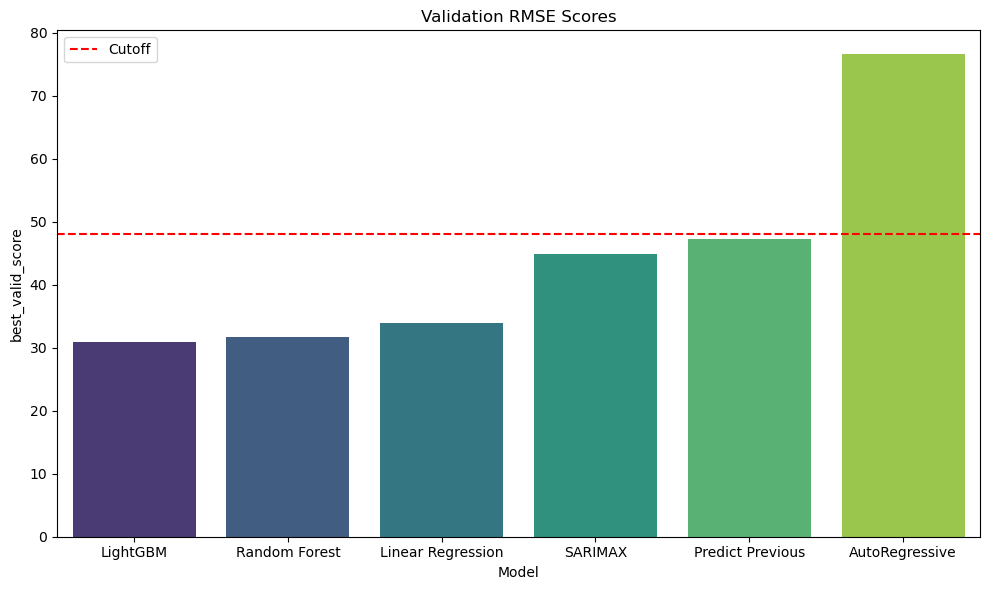

In [29]:
# Plot the best validation scores

plt.figure(figsize=(10, 6))
sns.barplot(x=results_df['description'], y=results_df['best_valid_score'], hue=results_df['description'], palette='viridis')
plt.title("Validation RMSE Scores")
plt.xlabel("Model")

# Draw cutoff line at 48
plt.axhline(y=48, color='r', linestyle='--', label='Cutoff')
plt.legend()
plt.show()

The absolute best performing model according to RMSE score is the LightGBM model, followed closely by the random forrest model. This exemplifies the benefits of gradient boosting.  

The AutoRegressive model performed the worst, nowhere near good enough for the standard set by Sweet Lift.

The auto_arima model was able to find a model (SARIMAX) that performed significantly better than the AutoRegressive model, but still only a little better than our baseline model that predicts known previous values.

The Linear regression is still competitive with the LightGBM model, and its simplicity may make it a better choice for Sweet Lift. We will test on the test set and evaluate their RMSE scores, training time, and prediction time.

In [30]:
# Test lightgbm model
def test_lgbm(df, row):
    
    # Make features
    data = make_features(df, row['best_lag'], row['best_rolling_mean']).dropna()

    # Split data
    train, test = train_test_split(data, shuffle=False, test_size=0.1)

    # Define features and target
    X_train = train.drop('num_orders', axis=1)
    y_train = train['num_orders']
    X_test = test.drop('num_orders', axis=1)
    y_test = test['num_orders']

    # Define the model
    model = LGBMRegressor(random_state=123, **row['best_params'])

    # Get the start time
    start = time.time()
    # Fit the model
    model.fit(X_train, y_train)
    
    # Get the training time
    training_time = time.time() - start

    start = time.time()
    # Make predictions
    pred = model.predict(X_test)
    
    # Get the prediction time
    pred_time = time.time() - start

    # Calculate the score
    score = mean_squared_error(y_test, pred, squared=False)
    
    # Plot the predictions and actual values
    plt.figure(figsize=(10, 6))
    plt.plot(test.index, y_test, label='Actual')
    plt.plot(test.index, pred, label='Predicted')
    plt.title(f"{row['description']} Predictions VS Actual")
    plt.xlabel("DateTime")
    plt.xticks(rotation=45)
    plt.ylabel("Taxi Orders")
    plt.legend()
    plt.show()
    
    # Store the results
    results = {
        'test_score': score,
        'training_time': training_time,
        'prediction_time': pred_time
    }
    
    return results 

In [31]:
def test_lr(df, row):
    
    # Make features
    data = make_features(df, row['best_lag'], row['best_rolling_mean']).dropna()

    # Split data
    train, test = train_test_split(data, shuffle=False, test_size=0.1)

    # Define features and target
    X_train = train.drop('num_orders', axis=1)
    y_train = train['num_orders']
    X_test = test.drop('num_orders', axis=1)
    y_test = test['num_orders']

    # Define the model
    model = LinearRegression()

    # Get the start time
    start = time.time()
    # Fit the model
    model.fit(X_train, y_train)
    
    # Get the training time
    training_time = time.time() - start

    start = time.time()
    # Make predictions
    pred = model.predict(X_test)
    
    # Get the prediction time
    pred_time = time.time() - start

    # Calculate the score
    score = mean_squared_error(y_test, pred, squared=False)
    
    # Plot the predictions and actual values
    plt.figure(figsize=(10, 6))
    plt.plot(test.index, y_test, label='Actual')
    plt.plot(test.index, pred, label='Predicted')
    plt.title(f"{row['description']} Predictions VS Actual")
    plt.xlabel("DateTime")
    plt.xticks(rotation=45)
    plt.ylabel("Taxi Orders")
    plt.legend()
    plt.show()
    
    # Store the results
    results = {
        'test_score': score,
        'training_time': training_time,
        'prediction_time': pred_time
    }
    
    return results

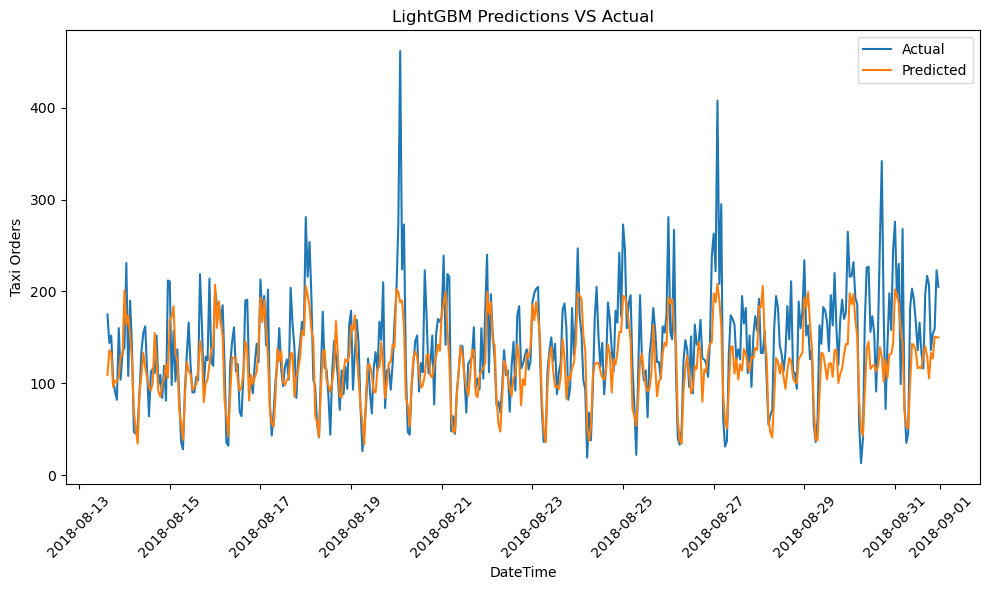

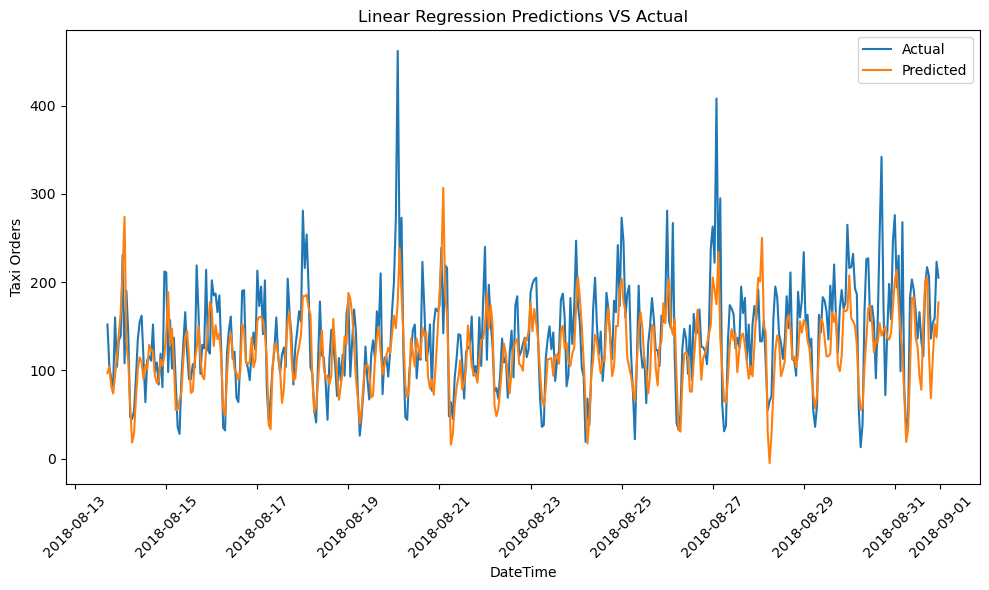

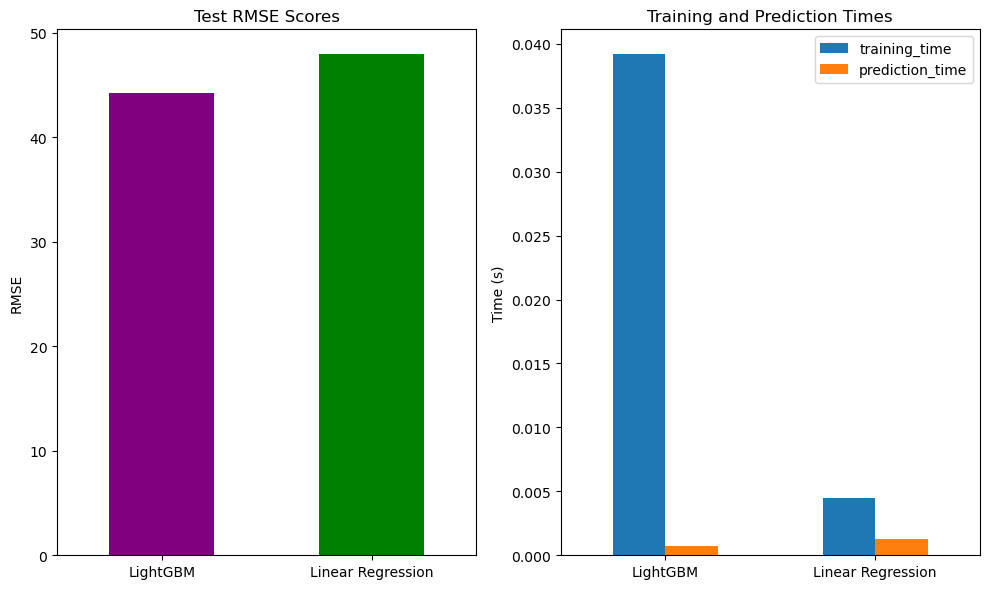


#### TEST SCORES ####
LightGBM: 44.26391031217571
Linear Regression: 47.925617295136206

#### TRAINING TIMES ####
LightGBM Training Time: 0.03917098045349121
Linear Regression Training Time: 0.004449129104614258

#### PREDICTION TIMES ####
LightGBM Prediction Time: 0.0007417201995849609
Linear Regression Prediction Time: 0.0012559890747070312

#### LGBM VS LR ####
RMSE: -3.661706982960496
Training Time: 0.03472185134887695
Prediction Time: -0.0005142688751220703


In [32]:
lgbm_test_results = test_lgbm(df, results_df.loc['lgbm_results'])
lr_test_results = test_lr(df, results_df.loc['lr_results'])

test_results_df = pd.DataFrame([lgbm_test_results, lr_test_results], index=['LightGBM', 'Linear Regression'])

# Create fig with two subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
# Plot the test scores
test_results_df['test_score'].plot(kind='bar', ax=ax[0], color=['purple', 'green'])
ax[0].set_title("Test RMSE Scores")
ax[0].set_ylabel("RMSE")
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0)

# Plot the training times and prediction times on the same plot
test_results_df[['training_time', 'prediction_time']].plot(kind='bar', ax=ax[1])
ax[1].set_title("Training and Prediction Times")
ax[1].set_ylabel("Time (s)")
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)

plt.show()

print("\n#### TEST SCORES ####")
print(f"LightGBM: {lgbm_test_results['test_score']}")
print(f"Linear Regression: {lr_test_results['test_score']}")
print("\n#### TRAINING TIMES ####")
print(f"LightGBM Training Time: {lgbm_test_results['training_time']}")
print(f"Linear Regression Training Time: {lr_test_results['training_time']}")
print("\n#### PREDICTION TIMES ####")
print(f"LightGBM Prediction Time: {lgbm_test_results['prediction_time']}")
print(f"Linear Regression Prediction Time: {lr_test_results['prediction_time']}")
print("\n#### LGBM VS LR ####")
print(f"RMSE: {lgbm_test_results['test_score'] - lr_test_results['test_score']}")
print(f"Training Time: {lgbm_test_results['training_time'] - lr_test_results['training_time']}")
print(f"Prediction Time: {lgbm_test_results['prediction_time'] - lr_test_results['prediction_time']}")


Although the Linear Regression model does train in about a third of a second faster than the LightGBM model, it has a higher RMSE (3.66 higher) and actually takes slightly longer (.0005 seconds) to calculate predictions.

# Conclusion

Given the significantly better performance on the test set of the LightGBM model, with only slightly more compute time, Sweet Lift should consider LightGMB model for their goal of predicting the amount of taxi orders for the next hour. They should implement `make_features(data, datalags=16, rolling_mean=4)` to their time series data before defining the model as `model = LGBMRegressor(**params)` where `params={'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 15}`.  

Additionally, further tuning could be explored with this model for possibly better results.